In [1]:
from pyhdf import SD
import numpy as np

from mpl_toolkits.basemap import Basemap, cm
import matplotlib.pyplot as plt
import sys

import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import pickle

import datetime
import glob

In [2]:
PATH = "../Downloads/Bengaluru-Nov-2019/hdfs/*.hdf"
FILE_LIST = glob.glob(PATH)  

save_pickle = True

In [3]:
idx = np.random.randint(len(FILE_LIST))

FILE_NAME = FILE_LIST[idx]

NAME = FILE_NAME.split('/')[-1]

print(f'{NAME} - Type: 1 KM')

MCD19A2.A2019315.h25v07.006.2019317054034.hdf - Type: 1 KM


In [4]:
hdf = SD.SD(FILE_NAME)
SDS_NAME = "Optical_Depth_047"

In [5]:
datasets = hdf.datasets()

In [6]:
len(datasets)

13

In [7]:
def extract_date_from_file_name(FILE_NAME):
    return datetime.datetime.strptime(FILE_NAME.split('/')[-1].split('.')[1:][0][1:], "%Y%j")

In [8]:
date_time = extract_date_from_file_name(NAME)

sn_data = np.genfromtxt('sn_bound_10deg.txt', 
                     skip_header = 7, 
                     skip_footer = 3)

lat = 12.9716 # Bengaluru Lat
lon = 77.5946 # Bengaluru Lon

flag = False
i = 0
while(not flag):
    flag = lat >= sn_data[i, 4] and lat <= sn_data[i, 5] and lon >= sn_data[i, 2] and lon <= sn_data[i, 3]
    i += 1

vertical   = sn_data[i-1, 0]
horizontal = sn_data[i-1, 1]

min_lon = sn_data[i-1, 2]
max_lon = sn_data[i-1, 3]

min_lat = sn_data[i-1, 4]
max_lat = sn_data[i-1, 5]

In [9]:
longitude, latitude = np.meshgrid(np.linspace(min_lon, max_lon, 1200),np.linspace(min_lat,max_lat, 1200))

sds = hdf.select(SDS_NAME)

attributes = sds.attributes()
scale_factor = attributes['scale_factor']
sds_range = sds.getrange()
min_range = min(sds_range)
max_range = max(sds_range)

data = sds.get()

fv = attributes['_FillValue']
data = data.astype(float)
data[data == fv] = np.nan

In [10]:
data.shape

(2, 1200, 1200)

In [11]:
data = np.nanmean(data, axis=0)

valid_data = data.ravel()
valid_data = [x for x in valid_data if x>=min_range]
valid_data = [x for x in valid_data if x<=max_range]
valid_data = np.asarray(valid_data)

valid_data = valid_data*scale_factor
average = sum(valid_data)/len(valid_data)
stdev = np.std(valid_data)

obj = {
    "latitude" : latitude,
    "longitude": longitude
}

pickle.dump(obj, open("mcd19a2.pkl", "wb"), protocol=4)

print("[INFO]")

print('The valid range of values is: ',round(min_range*scale_factor,3), ' to ',round(max_range*scale_factor,3),'\nThe average is: ',round(average,3),'\nThe standard deviation is: ',round(stdev,3))

print('The range of latitude in this file is: ', min_lat,' to ', max_lat, 'degrees \nThe range of longitude in this file is: ', min_lon, ' to ', max_lon,' degrees')

<ipython-input-11-b0c58f588d07>:1: RuntimeWarning: Mean of empty slice
  data = np.nanmean(data, axis=0)


[INFO]
The valid range of values is:  -0.1  to  5.0 
The average is:  0.573 
The standard deviation is:  0.216
The range of latitude in this file is:  10.0  to  20.0 degrees 
The range of longitude in this file is:  71.0799  to  85.1431  degrees


In [12]:
if save_pickle:

    bengaluru_geojson = gpd.read_file('../Municipal_Spatial_Data/Bengaluru/Bengaluru.geojson')
    bengaluru_geojson['city'] = 'Bengaluru'

    bounds = bengaluru_geojson['geometry'].apply(lambda x: x.bounds).values
    bounds = np.vstack(bounds)

    max_row = np.max(bounds, axis=0)
    min_row = np.min(bounds, axis=0)

    BENGALURU_B_MIN_LON, BENGALURU_B_MAX_LON = np.min([min_row[0], min_row[2]]), np.max([max_row[0], max_row[2]])
    BENGALURU_B_MIN_LAT, BENGALURU_B_MAX_LAT = np.min([min_row[1], min_row[3]]), np.max([max_row[1], max_row[3]])

    boundary = bengaluru_geojson.dissolve(by='city')['geometry'].values[0]

    lng_lat = np.stack((longitude, latitude),axis=2)
    mask = np.zeros(lng_lat.shape[:2])

    for i in range(lng_lat.shape[0]):
        mask[i] = [boundary.contains(Point(p)) for p in lng_lat[i]]

    mask = (mask > 0)

    obj = {
        "min_lon": BENGALURU_B_MIN_LON,
        "max_lon": BENGALURU_B_MAX_LON,
        "min_lat": BENGALURU_B_MIN_LAT,
        "max_lat": BENGALURU_B_MAX_LAT,
        "boundary": boundary,
        "bengaluru_mask": mask,
        "bengaluru_coords": np.array(list(zip(latitude[mask], longitude[mask])))
    }

    pickle.dump(obj, open("bengaluru_geodata.pkl", "wb"), protocol=4)

else:
    
    pkl_obj = pickle.load(open("bengaluru_geodata.pkl", "rb"))
    BENGALURU_B_MIN_LON, BENGALURU_B_MAX_LON = pkl_obj['min_lon'], pkl_obj['max_lon']
    BENGALURU_B_MIN_LAT, BENGALURU_B_MAX_LAT = pkl_obj['min_lat'], pkl_obj['max_lat']
    boundary = pkl_obj['boundary']
    mask = pkl_obj['bengaluru_mask']       

In [13]:
np.shape(data[mask]*scale_factor)

(604,)

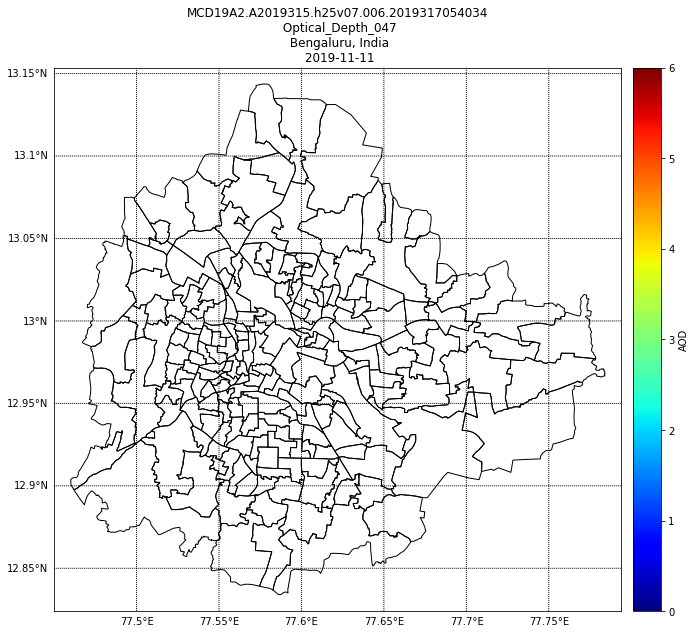

In [14]:
data = np.ma.masked_array(data, np.isnan(data))

plt.figure(figsize=(20, 10))
    
pad = 0.01

m = Basemap(projection='cyl', resolution='l', llcrnrlat=BENGALURU_B_MIN_LAT-pad, urcrnrlat=BENGALURU_B_MAX_LAT+pad, llcrnrlon=BENGALURU_B_MIN_LON-pad, urcrnrlon=BENGALURU_B_MAX_LON+pad , suppress_ticks=True)

m.readshapefile("../Municipal_Spatial_Data/Bengaluru/Bengaluru",'Bengaluru', linewidth=1)

m.drawparallels(np.arange(-90., 120., 0.05), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180., 181., 0.05), labels=[0, 0, 0, 1])
x, y = m(longitude[mask], latitude[mask])

sc = m.scatter(x, y, c=data[mask]*scale_factor, s=500, cmap=plt.cm.jet,
                    edgecolors='white', linewidth=0, marker='s')

plt.clim(0, 6)

cb = m.colorbar()
cb.set_label('AOD')

plotTitle = NAME[:-4]
plt.title('{0}\n {1}\n Bengaluru, India\n {2}'.format(plotTitle, SDS_NAME, date_time.strftime("%Y-%m-%d")))
fig = plt.gcf()

plt.show()

pngfile = 'images/{0}.png'.format(plotTitle)
fig.savefig(pngfile, bbox_inches="tight", dpi=400)